9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 314s 630ms/step - accuracy: 0.9433 - loss: 0.1596 - val_accuracy: 0.9678 - val_loss: 0.0861
Epoch 2/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 330s 651ms/step - accuracy: 0.9737 - loss: 0.0670 - val_accuracy: 0.9653 - val_loss: 0.0961
Epoch 3/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 301s 618ms/step - accuracy: 0.9794 - loss: 0.0598 - val_accuracy: 0.9665 - val_loss: 0.0941
Epoch 1/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 334s 672ms/step - accuracy: 0.9463 - loss: 0.1510 - val_accuracy: 0.9667 - val_loss: 0.0937
Epoch 2/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 394s 699ms/step - accuracy: 0.9657 - loss: 0.0917 - val_accuracy: 0.9644 - val_loss: 0.0999
Epoch 3/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 377s 690ms/step - accuracy: 0.9775 - loss: 0.0597 - val_accuracy: 0.9647 - val_loss: 0.1009
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


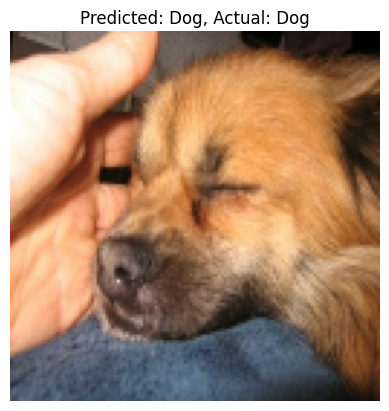

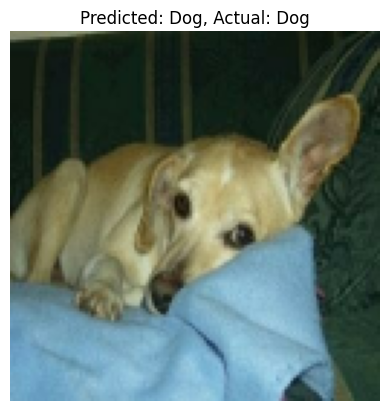

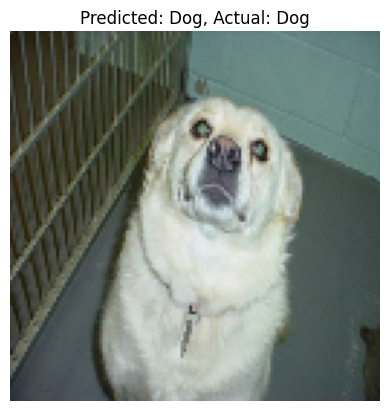

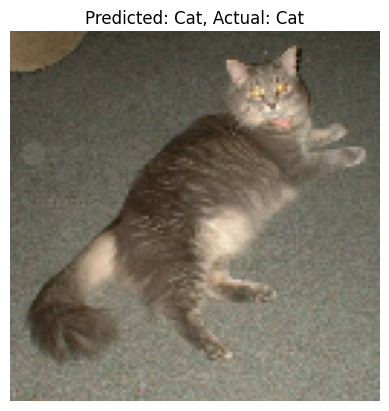

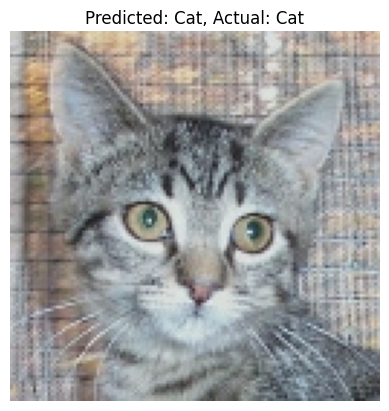

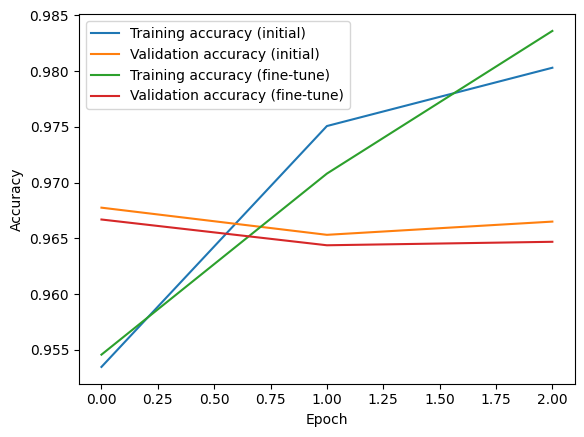

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

# Load the Cats vs. Dogs dataset from TensorFlow Datasets
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
train_ds = dataset['train']

# Preprocessing function
IMG_SIZE = (128, 128)  # Reduce image size for lower memory usage
BATCH_SIZE = 16  # Smaller batch size to reduce memory footprint

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# Preprocess and shuffle the dataset
train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(500).batch(BATCH_SIZE)  # Limit shuffle buffer
val_ds = train_ds.take(1000)  # Create a small validation set
train_ds = train_ds.skip(1000)  # Remaining for training

# Load a lightweight pre-trained model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with limited epochs and dataset size
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3  # Reduce epochs for quicker testing; increase as needed
)

# Fine-tuning: Unfreeze the last few layers and retrain
for layer in base_model.layers[-10:]:  # Unfreeze last few layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3  # Keep epochs low to prevent crashes
)

# Display a few predictions
sample_images, sample_labels = next(iter(val_ds.unbatch().batch(10)))  # Take 10 samples
predictions = model.predict(sample_images)
predictions_labels = np.where(predictions > 0.5, 1, 0)

# Plot some predictions with the actual labels
for i in range(5):  # Display first 5 images
    plt.imshow(sample_images[i].numpy())
    pred_label = 'Dog' if predictions_labels[i] == 1 else 'Cat'
    true_label = 'Dog' if sample_labels[i].numpy() == 1 else 'Cat'
    plt.title(f"Predicted: {pred_label}, Actual: {true_label}")
    plt.axis('off')
    plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training accuracy (initial)')
plt.plot(history.history['val_accuracy'], label='Validation accuracy (initial)')
plt.plot(history_finetune.history['accuracy'], label='Training accuracy (fine-tune)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation accuracy (fine-tune)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
